In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
from qiskit.opflow import X, Y, Z, I
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize as opt
from time import time


def create_hamiltonian(N): #crea l'hamiltoniana generale di ising dati i campi e n di qubits
    for q in range(N): #questo for crea i termini Hz,Hx,Hzz insieme H=gzz*Hz-gx*Hx-gz*Hz
        if q==0:
            opz=Z
            opx=X
            opzz=Z
        else:
            opz=I
            opx=I
            opzz=I
        if q==N-1:
            opzz=Z
        for i in range(1,N):
            if i==q:
                opz=opz^Z
                opx=opx^X
            else:
                opz=opz^I
                opx=opx^I
            if i==q or i==q+1:
                opzz=opzz^Z
            else:
                opzz=opzz^I
        if q==0:
            Hz=opz
            Hx=opx
            Hzz=opzz
        else:
            Hz=Hz+opz
            Hx=Hx+opx
            Hzz=Hzz+opzz
    return Hz,Hx,Hzz

def create_graph(N):
    g=[]
    for i in range(N):
        g.append((i,i+1))
        if i==N-2:
            g.append((N-1,0))
            break
    return g

def create_parameterized_circuit(N,p): #crea il circuito parametrico
    gamma=ParameterVector('gamma',p)
    beta=ParameterVector('beta',p)
    qr=QuantumRegister(N, 'q')
    qc=QuantumCircuit(qr)
    qc.h(qr[0:N])
    g=create_graph(N)
    for i in range(p):
        for edge in g: #cost layer, evolution with gzz*Hzz
            qc.cx(edge[0],edge[1])
            qc.rz(-2*gzz*gamma[i],edge[1])
            qc.cx(edge[0],edge[1])
        qc.rz(2*gz*gamma[i],qr[0:N]) #cost layer, evolution with -gz*Hz
        qc.rx(2*gx*beta[i],qr[0:N]) #mixer layer
    return qc

def expectation_value(parameters,estimator,qc,Htot): #calcola il valore dell'energia tramite l'estimator
    qc.assign_parameters(parameters,inplace=True)
    job = estimator.run(qc,Htot)
    result=job.result()
    return result.values[0]

def generate_random_parameters(p): #genera i parametri casualmente tra 0 e pi
    initial_parameters=np.empty(p) #al circuito vanno dati prima i beta in ordine e poi i gamma in ordine
    for i in range(p):
        initial_parameters[i]=np.random.uniform(0,2*np.pi)
    return initial_parameters

def compute_new_parameters(old_parameters,P): #metodo INTERP
    new_parameters=np.empty(P)
    new_parameters[0]=old_parameters[0]
    for i in range(P-1):
        new_parameters[i]=(i/(P-1))*old_parameters[i-1]+((P-1-i)/(P-1))*old_parameters[i]
    new_parameters[P-1]=old_parameters[P-2]
    return new_parameters

def optimization_via_INTERP(N,P_max):
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz-gx*Hx-gz*Hz
    optimizer=partial(opt,method='L-BFGS-B')
    qc=create_parameterized_circuit(N,1)
    estimator=Estimator()
    gammas=[0.1]
    betas=[0.1]
    new_parameters=betas+gammas
    start_time=time()
    optimized_parameters=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot).optimal_point
    for P in range(2,P_max+1):
        qc=create_parameterized_circuit(N,P)
        gammas=compute_new_parameters(gammas,P)
        betas=compute_new_parameters(betas,P)
        new_parameters=np.concatenate((betas,gammas))
        optimized_parameters=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot).optimal_point
    comput_time=time()-start_time
    return optimized_parameters,comput_time,expectation_value(optimized_parameters,estimator,create_parameterized_circuit(N,P_max),Htot)

In [4]:
gx=0.5 #campo trasverso
gz=0 #campo longitudinale
gzz=-1 #coef. davanti all'interazione (-1=ferro,+1=antiferro)
optimizer=partial(opt,method='L-BFGS-B')
estimator=Estimator()

In [73]:
#L'ESPERIMENTO CONSISTE NEL SIMULARE L'OTTIMIZZAZIONE TRAMITE INTERP PER P=4 E N=8 CON L-BFGS-B. POI PRENDO
#N=10,12,14,16 E UTILIZZO I PARAMETRI OTTIMALI PER N=8 SUI NUOVI VALORI DI N SEMPRE CON P=4.
#CALCOLO LA DIFFERENZA TRA IL TEMPO COMPUT. PER OTTIMIZZARE DA ZERO CON INTERP P=4 E UN DATO N E IL TEMPO CHE 
#CI METTO TRASFERENDO I PARAMETRI DI N=8 SUL NUOVO N E OTTIMIZZANDO DA LI'. CALCOLO INOLTRE LA DIFFERENZA DI ENERGIA
#NEI DUE CASI

In [64]:
time_diff_ratio=[]
energy_diff=[]
for N in range(10,18,2):
    P=4
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz-gx*Hx-gz*Hz
    qc=create_parameterized_circuit(N,P)
    start_time=time()
    optimized_parameters=VQE(estimator,qc,optimizer,initial_point=optimal_p4N8).compute_minimum_eigenvalue(Htot).optimal_point
    comput_time=time()-start_time
    total_comput_time_with_transf=comput_time+time_for_interp_optimization_p4N8
    optimal_par,time_for_interp,energy=optimization_via_INTERP(N,P)
    time_diff_ratio.append((time_for_interp-total_comput_time_with_transf)/time_for_interp)
    energy_diff.append(abs(energy-expectation_value(optimized_parameters,estimator,create_parameterized_circuit(N,P),Htot))/abs(energy))

In [65]:
time_diff_ratio,energy_diff

([0.09298587993076966,
  0.3269244476359429,
  0.6916264542525645,
  0.75595497558542],
 [2.1561276750868989e-10,
  1.710222385647141e-10,
  2.9625754674534074e-10,
  5.39776846863993e-10])

In [66]:
time_diff_ratio=np.array(time_diff_ratio)
energy_diff=np.array(energy_diff)
N_list=np.array([10,12,14,16])

In [70]:
#QUI FACCIO IL PLOT DELLA FRAZIONE DI TEMPO RISPARMIATA E DELLA DIFFERENZA DI ENERGIA 

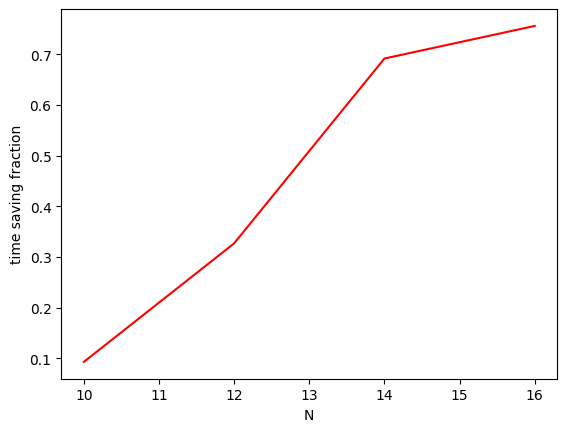

In [68]:
plt.plot(N_list,time_diff_ratio,color='red')
plt.xlabel('N')
plt.ylabel('time saving fraction')
plt.show()

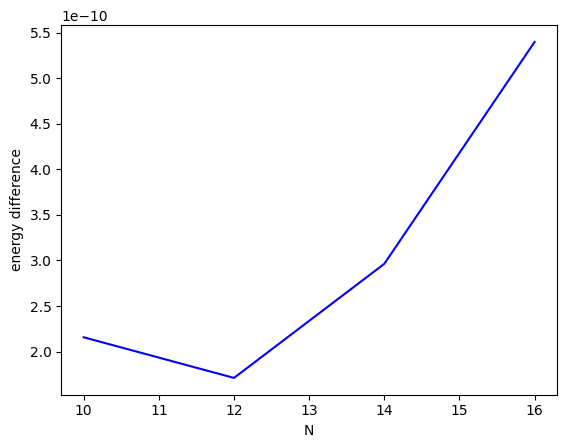

In [69]:
plt.plot(N_list,energy_diff,color='blue')
plt.xlabel('N')
plt.ylabel('energy difference')
plt.show()

In [3]:
#RISULTA CHE LA FRAZIONE DI TEMPO RISPARMIATA E' CRESCENTE IN N (E DI PARECCHIO) MENTRE L'ENERGIA RIMANE PRESSOCHE' 
#COSTANTE (TIENI IN CONTO CHE NEL PLOT C'E' UN FATTORE 10^-10)

In [11]:
energy_diff_no_opt=[]
optimized_parameters=optimization_via_INTERP(8,4)[0]
for N in range(10,18,2):
    P=4
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz-gx*Hx-gz*Hz
    qc=create_parameterized_circuit(N,P)
    energy_one_shot=expectation_value(optimized_parameters,estimator,create_parameterized_circuit(N,P),Htot)
    print([N,energy_one_shot])
    optimum=VQE(estimator,qc,optimizer,initial_point=optimized_parameters).compute_minimum_eigenvalue(Htot).optimal_point
    energy_optimal=expectation_value(optimum,estimator,create_parameterized_circuit(N,P),Htot)
    print([N,energy_optimal])
    energy_diff_no_opt.append(1-abs(energy_optimal-energy_one_shot)/abs(energy_optimal))

[10, -8.13505541030837]
[10, -9.635283681659079]
[12, -9.762066492370046]
[12, -11.56234041791812]
[14, -11.389077574431706]
[14, -13.48939715422995]
[16, -13.01608865649338]
[16, -15.416453890803488]


In [15]:
1-(15.416453890803488-13.01608865649338)/15.416453890803488

0.8442984845080347

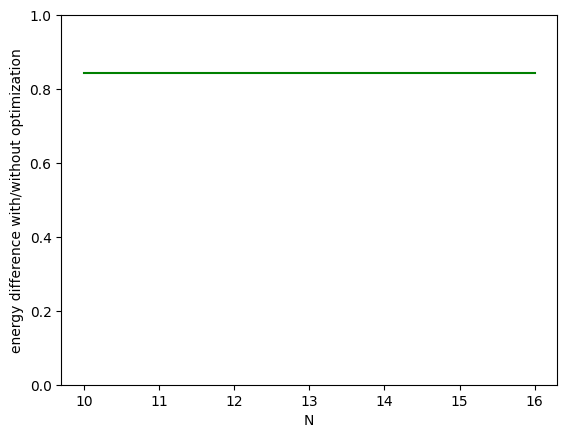

In [19]:
N_list=[10,12,14,16]
plt.plot(N_list,energy_diff_no_opt,color='green')
plt.ylim([0,1])
plt.xlabel('N')
plt.ylabel('energy difference with/without optimization')
plt.show()

In [20]:
#USANODO I PARAMETRI PER N=8 E P=4 SU UN NUMERO DI QUBIT DIVERSO ONE-SHOT, L'ALGO TROVA UN'ENERGIA CHE E' 
#SEMPRE LA STESSA FRAZIONE DELL'ENERGIA MINIMA CHE L'ALGO TROVA DOPO UNA REFINEMENT OPTIMIZATION!!!